**Импортируем pandas и сам датасет**

In [1]:
import pandas as pd

df = pd.read_csv("jamb_exam_results.csv")
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


## Предварительная обработка данных
**Подготавливаем данные, приводим названия столбцов к нижнему регистру**

In [2]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


**Удаляем столбец `student_id` и заполняем пропуски нулями**

In [3]:
df = df.drop(["student_id"], axis=1)
df = df.fillna(0)
df.isnull().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

**Отделяем целевую переменную от остального датасета**

In [4]:
from sklearn.model_selection import train_test_split

x = df.drop(["jamb_score"], axis=1)
y = df["jamb_score"]

**Делаем разделение на _temp_ и _test_**

In [5]:
x_temp, x_test, y_temp, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=1
)

**Далее делим на _train_ и _val_**

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp,
    test_size=0.25,
    random_state=1
)

**Применяем преобразование датафрейма в матрицу с помощью `DictVectorizer`**

In [7]:
from sklearn.feature_extraction import DictVectorizer

train_dict = x_train.to_dict(orient="records")
val_dict = x_val.to_dict(orient="records")
test_dict = x_test.to_dict(orient="records")

vec = DictVectorizer(sparse=True)

x_train = vec.fit_transform(train_dict)
x_val = vec.transform(val_dict)
x_test = vec.transform(test_dict)

## Вопрос 1
**Обучаем дерево решений с параметром `max_depth=1`**

In [8]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(x_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


**Находим признак, который использовался для разбиения данных**

In [9]:
feature_names = vec.get_feature_names_out()
root_feature_index = dt.tree_.feature[0]
root_feature = feature_names[root_feature_index]

root_feature

'study_hours_per_week'

**Ответ: `study_hours_per_week`**

## Вопрос 2
**Обучаем случайный лес со следующими параметрами: `n_estimators=10`, `random_state=1`, `n_jobs=-1`**

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_val)

rmse = round(root_mean_squared_error(y_pred, y_val), 2)
rmse

42.14

**Ответ: на валидационных данных _RMSE_=42.14**

## Вопрос 3
**Теперь будем изменять параметр `n_estimators` с последующей оценкой модели на _validation_**

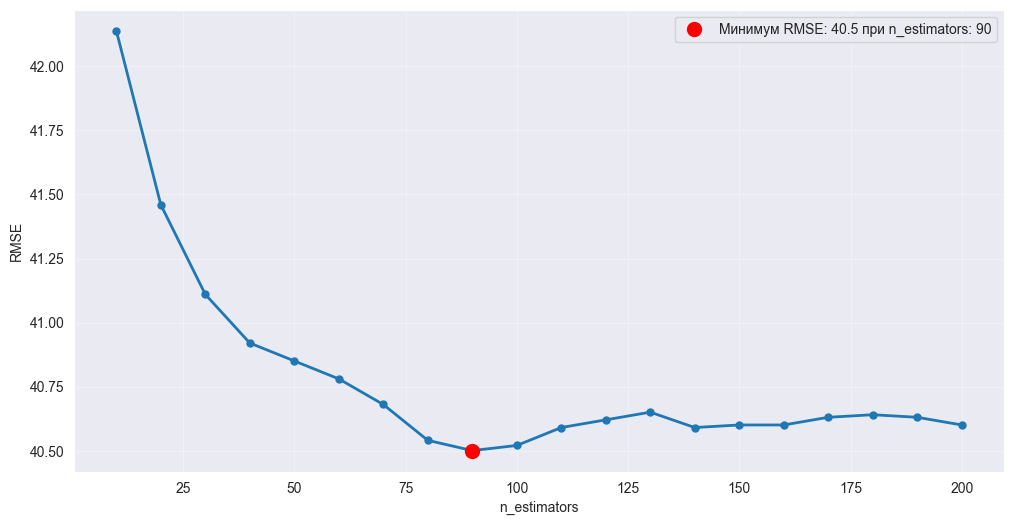

In [11]:
import matplotlib.pyplot as plt

rmse_scores = {}

for n_estimators in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(x_train, y_train)

    y_pred = rf.predict(x_val)

    rmse = round(root_mean_squared_error(y_pred, y_val), 2)
    rmse_scores[n_estimators] = rmse

plt.figure(figsize=(12, 6))
n_estimators_list = list(rmse_scores.keys())
rmse_values = list(rmse_scores.values())

plt.plot(n_estimators_list, rmse_values, marker="o", linewidth=2, markersize=5)
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)

min_rmse = min(rmse_values)
min_n = n_estimators_list[rmse_values.index(min_rmse)]
plt.scatter(min_n, min_rmse, color="red", s=100, zorder=5, label=f"Минимум RMSE: {min_rmse} "
                                                                 f"при n_estimators: {min_n}")

plt.legend()
plt.show()

**Ответ: по графику видно, что при `n_estimators=90` достигается лучшее значение _RMSE_=40.5, потом идёт ухудшение метрики**

## Вопрос 4
**Продолжим работать с параметрами модели, будем изменять параметры `max_depth` и `n_estimators`**

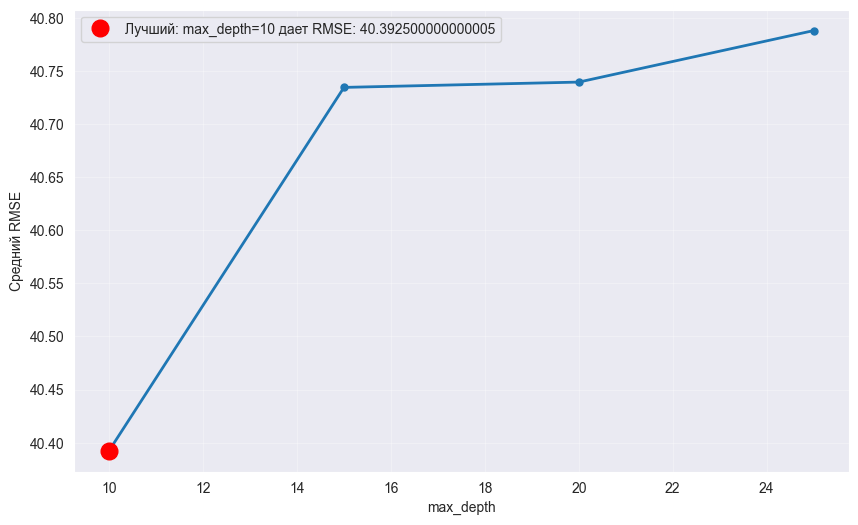

In [12]:
import numpy as np

res = {}

for max_depth in [10, 15, 20, 25]:
    rmse_scores = []

    for n_estimators in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                   random_state=1, n_jobs=-1)
        rf.fit(x_train, y_train)

        y_pred = rf.predict(x_val)

        rmse = round(root_mean_squared_error(y_pred, y_val), 2)
        rmse_scores.append(rmse)

    mean_rmse = np.mean(rmse_scores)
    res[max_depth] = mean_rmse

plt.figure(figsize=(10, 6))

max_depth_list = list(res.keys())
rmse_values = list(res.values())

plt.plot(max_depth_list, rmse_values, marker="o", linewidth=2, markersize=5)

best_max_depth = min(res, key=res.get)
best_rmse = res[best_max_depth]

plt.plot(best_max_depth, best_rmse, "ro", markersize=12, label=f"Лучший: max_depth={best_max_depth} "
                                                               f"дает RMSE: {best_rmse}")

plt.xlabel("max_depth")
plt.ylabel("Средний RMSE")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

**Ответ: по графику видно, что лучшее значение среднего _RMSE_ достигается при `max_depth=10`**

## Вопрос 5
**Оценим важность признаков для модели**

In [13]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

feature_importances = rf.feature_importances_
feature_names = vec.get_feature_names_out()

importance_dict = dict(zip(feature_names, feature_importances))
sorted_importance_dict = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_importance_dict[0][0], sorted_importance_dict[0][1])

study_hours_per_week 0.2483536119939654


**Ответ: из `feature_importances_` мы видим, что наибольшая важность у `study_hours_per_week` и она равна 0.2483536119939654**

## Ответы на вопросы:
**1. Ответ: `study_hours_per_week`**\
**2. Ответ: на валидационных данных _RMSE_=42.14**\
**3. Ответ: по графику видно, что при `n_estimators=90` достигается лучшее значение _RMSE_=40.5, потом идёт ухудшение метрик**\
**4. Ответ: по графику видно, что лучшее значение среднего _RMSE_ достигается при `max_depth=10`**\
**5. Ответ: из `feature_importances_` мы видим, что наибольшая важность у `study_hours_per_week` и она равна 0.2483536119939654**
